# Préambule

In [1]:
import sys
import importlib
import os
from pathlib import Path

sys.path.insert(1, str(Path(os.getcwd()).parent))

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

In [3]:
from speed_constraint import calculate_latency_metrics
from math import ceil

def direct_method_streamlit(
  concurrent_users: int, 
  batch_size: int,
  gpu_troughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  model_layers: int,
  model_hidden_dim: int,
  bytes_per_param: float,
  input_length: int = 100,
  output_length: int = 1650,
  n_gpus: int = 1,
):
    """
    Calcul du TTFT moyen à partir des formules de calculate_speed_constraint dans speed_constraint.py
    Le code commenté correspond aux formules de calculate_latency_metrics mais est moins fiable
    """
    GPU_EFFICIENCY_FACTOR = 0.55  # Default efficiency factor (~55% for fp16)
    MULTI_GPU_INEFFICIENCY_FACTOR = 0.85
    
    effective_bandwidth = gpu_bandwidth * (1 + (n_gpus - 1) * MULTI_GPU_INEFFICIENCY_FACTOR)
    effective_gpu_flops = (gpu_troughput * GPU_EFFICIENCY_FACTOR) * (1 + (n_gpus - 1) * MULTI_GPU_INEFFICIENCY_FACTOR)

    effective_batchs = ceil(concurrent_users / batch_size)
    wait_factor = ((effective_batchs - 1) * effective_batchs / 2) / concurrent_users

    # flops_per_token = model_params * 2
    # gpu_tps = effective_gpu_flops / flops_per_token

    # latency_metrics = calculate_latency_metrics(
    #     gpu_tps, input_length, output_length, batch_size
    # )
    
    # return latency_metrics["ttft_ms"] / 1000 + latency_metrics["total_time_s"] * wait_factor

    generated_tokens = output_length

    flops_prefill = 2 * batch_size * model_layers * input_length * model_hidden_dim * (2*model_hidden_dim + input_length)
    mm_prefill = bytes_per_param * (model_params + 2 * model_layers * batch_size * input_length * model_hidden_dim + batch_size * input_length * model_hidden_dim)
    time_prefill = max(flops_prefill / effective_gpu_flops, mm_prefill / effective_bandwidth)

    flops_decode_one_token = batch_size * model_params * 2
    mm_params = model_params
    mm_kv_read = 2 * batch_size * input_length * model_hidden_dim
    mm_kv_write = 2 * batch_size * model_hidden_dim
    # mm_activations = 2 * batch_size * input_length * model_layers * model_hidden_dim
    mm_decode_one_token = bytes_per_param * (mm_params + mm_kv_read + mm_kv_write)
    time_decode_one_token = max(flops_decode_one_token / effective_gpu_flops, mm_decode_one_token / effective_bandwidth)

    # print(f"users: {concurrent_users}, time_prefill: {time_prefill}, tps: {1/time_decode_one_token}")

    total_time = time_prefill + (generated_tokens - 1) * time_decode_one_token

    return time_prefill + wait_factor * total_time




In [4]:
def direct_method_bis(
    concurrent_users: int,
    batch_size: int,
    gpu_troughput: float,
    gpu_bandwidth: float,
    model_params: int,
    model_layers: int,
    model_hidden_dim: int,
    bytes_per_param: float,
    input_length: int = 100,
    output_length: int = 1650,
    n_gpus: int = 1,
    link_bw: float = 100e9,
):
    """
    Latency model with minimal multi‑GPU & small‑model fixes.

    * Tensor‑parallel efficiency and comm‑overhead are modelled explicitly.
    * FLOPs/BW terms use a roofline: time = max(FLOPs/TFLOPs, Bytes/BW).
    * Parameter / KV access is sharded when n_gpus > 1.
    """

    # -------------------------------- calibration -------------------------------- #
    GPU_EFFICIENCY_FACTOR   = 0.55   # fp16 utilisation for large models; tune per GPU
    TP_EFFICIENCY           = 0.85   # tensor‑parallel scaling loss (NVLink H100)
    COMM_OVERHEAD_FRACTION  = 0.15   # all‑reduce latency fudge factor
    # ----------------------------------------------------------------------------- #

    per_gpu_flops   = gpu_troughput * GPU_EFFICIENCY_FACTOR
    per_gpu_bw      = gpu_bandwidth
    aggregate_flops = per_gpu_flops * n_gpus * TP_EFFICIENCY
    aggregate_bw    = per_gpu_bw  * n_gpus

    # queueing / batching
    effective_batches = ceil(concurrent_users / batch_size)
    wait_factor = ((effective_batches - 1) * effective_batches / 2) / concurrent_users

    # ---------- pre‑fill (prompt) ---------- #
    flops_prefill = (
        2 * batch_size * model_layers * input_length * model_hidden_dim
        * (2 * model_hidden_dim + input_length)
    )
    mm_prefill = bytes_per_param * (
        model_params
        + 2 * model_layers * batch_size * input_length * model_hidden_dim
        + batch_size * input_length * model_hidden_dim
    )
    time_prefill = max(flops_prefill / aggregate_flops, mm_prefill / aggregate_bw)

    # ---------- decode (one token) ---------- #
    # compute term is sharded
    flops_decode_one = batch_size * (model_params / n_gpus) * 2

    # memory term is also per‑GPU
    mm_params  = model_params / n_gpus
    mm_kv_read = 2 * batch_size * input_length * model_hidden_dim
    mm_kv_write = 2 * batch_size * model_hidden_dim
    mm_decode_one = bytes_per_param * (mm_params + mm_kv_read + mm_kv_write)

    # comm: one all‑reduce of qkv activations per layer (very coarse)
    comm_bytes = model_layers * 2 * model_hidden_dim * 4   # fp16→2 B, 2 directions
    comm_time  = (comm_bytes / link_bw) * COMM_OVERHEAD_FRACTION

    time_decode_one = max(
        flops_decode_one / aggregate_flops,
        mm_decode_one  / aggregate_bw,
    ) + comm_time

    # ---------- total ---------- #
    generated_tokens = output_length
    stream_time = time_prefill + (generated_tokens - 1) * time_decode_one
    return time_prefill + wait_factor * stream_time

In [5]:
from calibration.queue_analysis import mm1_transient_mean, mm1_transient_percentile
from math import ceil

def queue_theory_method(
  concurrent_users: int, 
  batch_size: int,
  gpu_troughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  bytes_per_param: float,
  model_layers: int = 2,
  model_hidden_dim: int = 2,
  n_gpus: int = 1,
  input_length: int = 100,
  output_length: int = 1650,
  link_bw: float = 100e9,
  ):
    """
    Calcul du TTFT moyen à partir d'un modèle de file d'attente M/M/c dont on
    estime les probabilités transcientes avec les méthodes de queue_analysis.py
    """
    
    theta = 0.5 # hyperparamètre qui dépend du comportement des utilisteurs
    h100_bandwidth = 3.2e12 # pour recalibration sur d'autres GPUs
    mistral_small_layers = 40 # pour recalibration sur d'autres modèles

    output_length = 1650 / 4

    # -------------------------------- calibration -------------------------------- #
    GPU_EFFICIENCY_FACTOR   = 0.55   # fp16 utilisation for large models; tune per GPU
    TP_EFFICIENCY           = 0.85   # tensor‑parallel scaling loss (NVLink H100)
    COMM_OVERHEAD_FRACTION  = 0.15   # all‑reduce latency fudge factor
    # ----------------------------------------------------------------------------- #

    per_gpu_flops   = gpu_troughput * GPU_EFFICIENCY_FACTOR
    per_gpu_bw      = gpu_bandwidth
    aggregate_flops = per_gpu_flops * n_gpus * TP_EFFICIENCY
    aggregate_bw    = per_gpu_bw  * n_gpus

    # queueing / batching
    effective_batches = ceil(concurrent_users / batch_size)
    wait_factor = ((effective_batches - 1) * effective_batches / 2) / concurrent_users

    # ---------- pre‑fill (prompt) ---------- #
    flops_prefill = (
        2 * batch_size * model_layers * input_length * model_hidden_dim
        * (2 * model_hidden_dim + input_length)
    )
    mm_prefill = bytes_per_param * (
        model_params
        + 2 * model_layers * batch_size * input_length * model_hidden_dim
        + batch_size * input_length * model_hidden_dim
    )
    time_prefill = max(flops_prefill / aggregate_flops, mm_prefill / aggregate_bw)

    # ---------- decode (one token) ---------- #
    # compute term is sharded
    flops_decode_one = batch_size * (model_params / n_gpus) * 2

    # memory term is also per‑GPU
    mm_params  = model_params / n_gpus
    mm_kv_read = 2 * batch_size * input_length * model_hidden_dim
    mm_kv_write = 2 * batch_size * model_hidden_dim
    mm_decode_one = bytes_per_param * (mm_params + mm_kv_read + mm_kv_write)

    # comm: one all‑reduce of qkv activations per layer (very coarse)
    comm_bytes = model_layers * 2 * model_hidden_dim * 4   # fp16→2 B, 2 directions
    comm_time  = (comm_bytes / link_bw) * COMM_OVERHEAD_FRACTION

    time_decode_one = max(
        flops_decode_one / aggregate_flops,
        mm_decode_one  / aggregate_bw,
    ) + comm_time

    # ---------- total ---------- #
    generated_tokens = output_length
    time_per_request = time_prefill + (generated_tokens - 1) * time_decode_one

    # paramètres de la queue
    mu_heuristic = 2*(h100_bandwidth/gpu_bandwidth) * (mistral_small_layers/model_layers)
    λ = concurrent_users / time_per_request
    μ = (1/time_per_request) * batch_size


    # calculs
    t = ceil(time_per_request)
    mean_queue_length = mm1_transient_mean(λ, μ, 1, n_states=1000)
    # percentile_queue_length = mm1_transient_percentile(λ, μ, t, 0.95)

    wait_time = mean_queue_length / μ

    # print(f"λ = {round(λ, 3)}, μ = {round(μ, 3)}, t = {round(time_per_request, 3)}, tps = {round(1/time_decode_one, 3)}, W(1) = {round(wait_time, 3)}, L(1) = {mean_queue_length}")

    return time_prefill + wait_time


In [6]:
def get_predictions(
  x: list,
  batch_size: int,
  gpu_troughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  bytes_per_param: float,
  output_lengths: list,
  model_layers: int,
  model_hidden_dim: int,
  n_gpus: int = 1,
  input_length: int = 100,
):
  direct_pred = []
  direct_pred_bis = []
  queue_pred = []
  for concurrent_users, output_length in zip(x, output_lengths):
    direct_pred.append(direct_method_streamlit(
      concurrent_users=concurrent_users,
      batch_size=batch_size,
      gpu_troughput=gpu_troughput,
      gpu_bandwidth=gpu_bandwidth,
      model_params=model_params,
      model_layers=model_layers,
      model_hidden_dim=model_hidden_dim,
      bytes_per_param=bytes_per_param,
      input_length=input_length,
      output_length=output_length,
      n_gpus=n_gpus
    ))
    direct_pred_bis.append(direct_method_bis(
      concurrent_users=concurrent_users,
      batch_size=batch_size,
      gpu_troughput=gpu_troughput,
      gpu_bandwidth=gpu_bandwidth,
      model_params=model_params,
      model_layers=model_layers,
      model_hidden_dim=model_hidden_dim,
      bytes_per_param=bytes_per_param,
      input_length=input_length,
      output_length=output_length,
      n_gpus=n_gpus
    ))
    queue_pred.append(queue_theory_method(
      concurrent_users=concurrent_users,
      batch_size=batch_size,
      gpu_troughput=gpu_troughput,
      gpu_bandwidth=gpu_bandwidth,
      model_params=model_params,
      model_layers=model_layers,
      model_hidden_dim=model_hidden_dim,
      bytes_per_param=bytes_per_param,
      n_gpus=n_gpus,
      input_length=input_length,
      output_length=output_length
    ))
  return queue_pred, direct_pred, direct_pred_bis

# Comparaisons sur TTFT

On essaiera plus tard de faire des comparaisons sur le troughput en tokens/sec

## Mistral small

### 1 H100

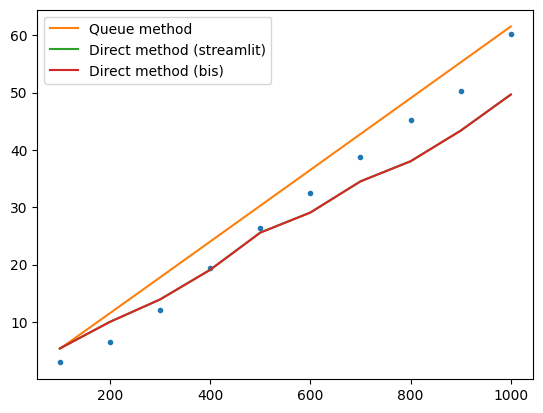

In [7]:
df = pd.read_csv("load_test_mistral.csv", sep=";")

y = df.iloc[:, 3]
output_lengths = df.iloc[:, 7]

x = [i*100 for i in range(1, 11)]
y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  model_layers=40,
  model_hidden_dim=5120,
  bytes_per_param=2,
  output_lengths=output_lengths,
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()
# plt.plot(x_predict, [b/100 + m*x/100 for x in x_predict])

C'est pas mal !

In [8]:
print("MSE queue method: ", mean_squared_error(y, y_predict[0]))
print("MSE direct method: ", mean_squared_error(y, y_predict[1]))
print("MSE direct(bis) method: ", mean_squared_error(y, y_predict[2]))

MSE queue method:  17.498033040316887
MSE direct method:  26.074125154093803
MSE direct(bis) method:  26.03204247311171


### 1 A100

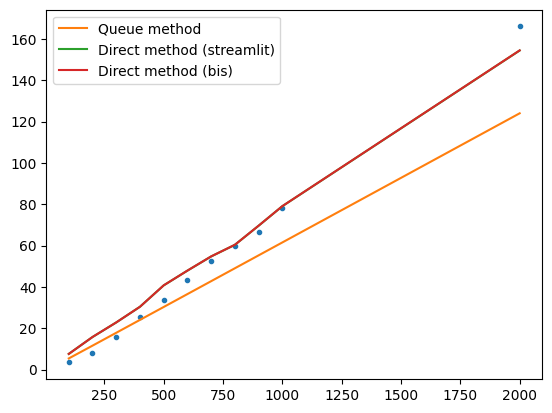

In [9]:
df = pd.read_csv("load_test_mistral_A100.csv", sep=";")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]

x = [i*100 for i in range(1, 11)] + [2000]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=3.12e14,
  gpu_bandwidth=2e12,
  model_params=24e9,
  model_layers=40,
  model_hidden_dim=5120,
  bytes_per_param=2,
  n_gpus=1,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

In [10]:
print("MSE queue method: ", mean_squared_error(y, y_predict[0]))
print("MSE direct method: ", mean_squared_error(y, y_predict[1]))
print("MSE direct(bis) method: ", mean_squared_error(y, y_predict[2]))

MSE queue method:  225.10533672172357
MSE direct method:  33.69818933002577
MSE direct(bis) method:  33.71517710201095


### 2 H100

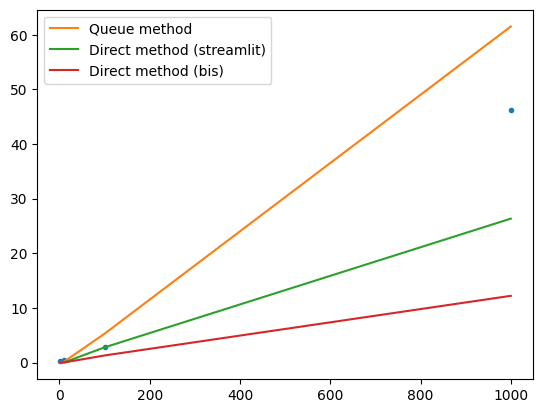

In [11]:
df = pd.read_csv("load_test_mistral_2H100.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]

x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  bytes_per_param=2,
  model_layers=40,
  model_hidden_dim=5120,
  n_gpus=2,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()


In [12]:
print("MSE queue method: ", mean_squared_error(y, y_predict[0]))
print("MSE direct method: ", mean_squared_error(y, y_predict[1]))
print("MSE direct(bis) method: ", mean_squared_error(y, y_predict[2]))

MSE queue method:  60.67726072613588
MSE direct method:  98.11775777746197
MSE direct(bis) method:  288.45005566325017


## LLama 3.1 8b

### 1 H100

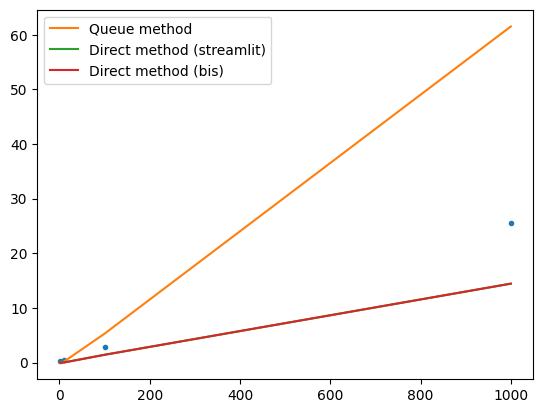

In [13]:
df = pd.read_csv("load_test_meta_H100.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]

x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=8e9,
  bytes_per_param=2,
  model_layers=32,
  model_hidden_dim=4096,
  n_gpus=1,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

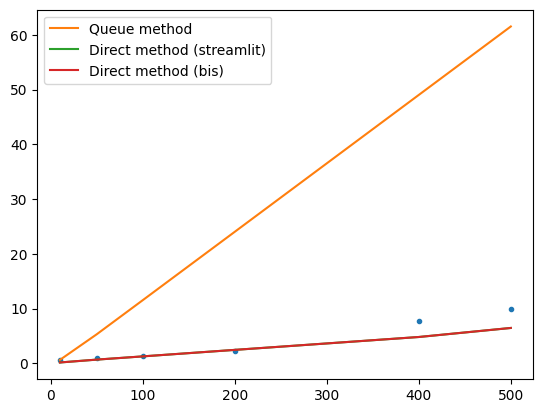

In [14]:
df = pd.read_csv("load_test_meta_H100_2.csv", sep=",")

y = df.iloc[:, 3]
output_lengths = df.iloc[:, 10]

x = [10, 50, 100, 200, 400, 500]

y_predict = get_predictions(
  x=x,
  batch_size=8,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=8e9,
  bytes_per_param=2,
  model_layers=32,
  model_hidden_dim=4096,
  n_gpus=1,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

In [15]:
print("MSE queue method: ", mean_squared_error(y, y_predict[0]))
print("MSE direct method: ", mean_squared_error(y, y_predict[1]))
print("MSE direct(bis) method: ", mean_squared_error(y, y_predict[2]))

MSE queue method:  826.1963179244631
MSE direct method:  3.5494011164256505
MSE direct(bis) method:  3.545591207688698


### A100

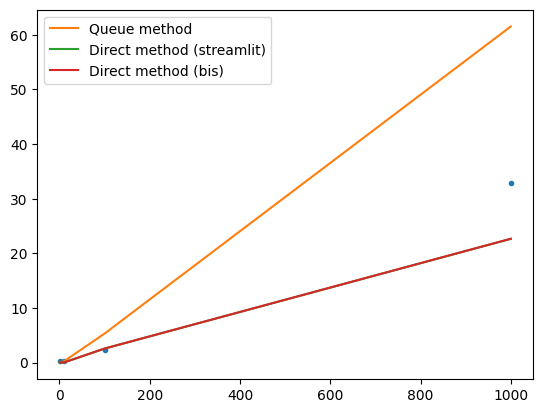

In [16]:
df = pd.read_csv("load_test_meta_A100.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]

x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=3.12e14,
  gpu_bandwidth=2e12,
  model_params=8e9,
  bytes_per_param=2,
  model_layers=32,
  model_hidden_dim=4096,
  n_gpus=1,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

In [17]:
print("MSE queue method: ", mean_squared_error(y, y_predict[0]))
print("MSE direct method: ", mean_squared_error(y, y_predict[1]))
print("MSE direct(bis) method: ", mean_squared_error(y, y_predict[2]))

MSE queue method:  208.70648975207186
MSE direct method:  25.738543452420608
MSE direct(bis) method:  25.662295914137257


### 2 H100

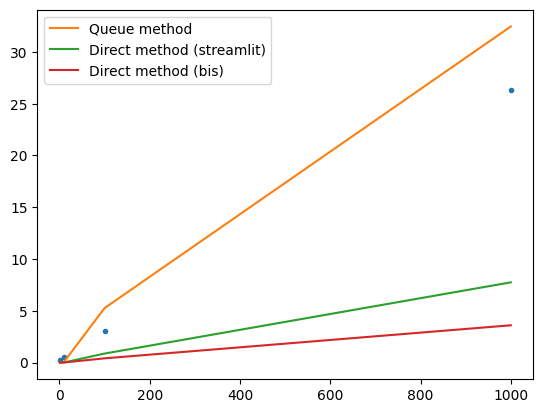

In [18]:
df = pd.read_csv("load_test_meta_2H100.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]

x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=8e9,
  bytes_per_param=2,
  model_layers=32,
  model_hidden_dim=4096,
  n_gpus=2,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

## Gemma 27b

### 1 H100

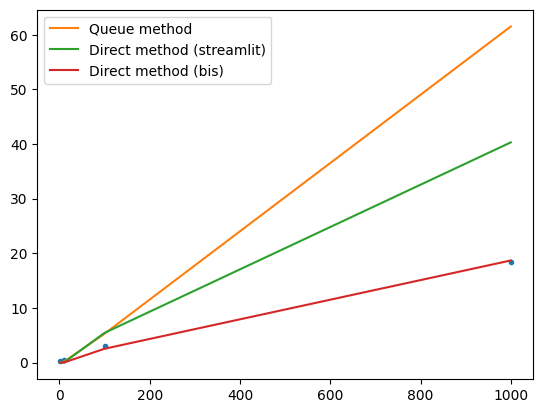

In [19]:
df = pd.read_csv("load_test_google_H100.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]
x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=27e9,
  bytes_per_param=2,
  model_layers=60,
  model_hidden_dim=5376,
  n_gpus=2,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

A noter qu'on a 82,42% de requêtes qui échouent à 1000 requêtes concurrentes. Le fait que les formules du streamlit soient performantes à 1000 requêtes relève probablement du hasard.

## 2 H100

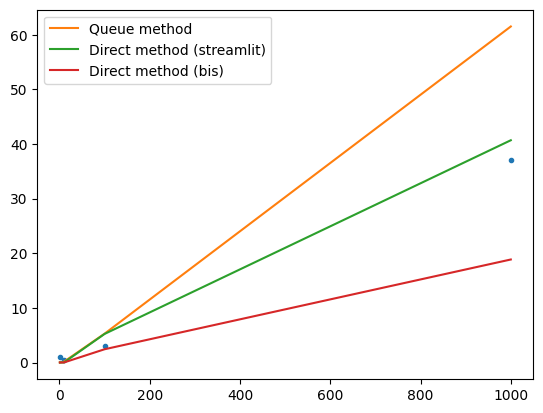

In [20]:
df = pd.read_csv("load_test_google_2H100.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]
x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=27e9,
  bytes_per_param=2,
  model_layers=60,
  model_hidden_dim=5376,
  n_gpus=2,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

## mistral anciennes données

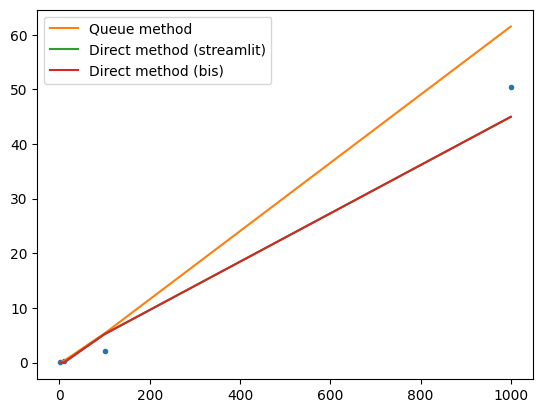

In [21]:
df = pd.read_csv("load_test_mistral_H100_old.csv", sep=",")

y = df.iloc[:-1, 3]
output_lengths = df.iloc[:-1, 7]

x = [1] + [10**k for k in range(1, 4)]

y_predict = get_predictions(
  x=x,
  batch_size=16,
  gpu_troughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  bytes_per_param=2,
  model_layers=40,
  model_hidden_dim=5120,
  n_gpus=1,
  output_lengths=output_lengths
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Queue method")
plt.plot(x, y_predict[1], label="Direct method (streamlit)")
plt.plot(x, y_predict[2], label="Direct method (bis)")
plt.legend()

# Comparaisons tokens/seconde

Par défaut les prédictions du modèle pour le throughput ne dépendent pas du nombre de requêtes concurrentes, on a ajouté en amont un facteur correctif de `k/log(concurrent_users)` qui suit assez fidèlement l'évolution du throughput mesurée empiriquement en fonction du nombre de requêtes concurrentes. 

In [22]:
from math import sqrt, log, exp

def direct_method(
    concurrent_users: int,
    batch_size: int,
    gpu_throughput: float,
    gpu_bandwidth: float,
    model_params: int,
    model_layers: int,
    model_hidden_dim: int,
    bytes_per_param: float,
    k: float,
    input_length: int = 100,
    output_length: int = 1650,
    n_gpus: int = 1,
    link_bw: float = 100e9,
):
    """
    Latency model with minimal multi‑GPU & small‑model fixes.

    * Tensor‑parallel efficiency and comm‑overhead are modelled explicitly.
    * FLOPs/BW terms use a roofline: time = max(FLOPs/TFLOPs, Bytes/BW).
    * Parameter / KV access is sharded when n_gpus > 1.
    """

    # -------------------------------- calibration -------------------------------- #
    GPU_EFFICIENCY_FACTOR   = 0.55   # fp16 utilisation for large models; tune per GPU
    TP_EFFICIENCY           = 0.85   # tensor‑parallel scaling loss (NVLink H100)
    COMM_OVERHEAD_FRACTION  = 0.15   # all‑reduce latency fudge factor
    # ----------------------------------------------------------------------------- #

    per_gpu_flops   = gpu_throughput * GPU_EFFICIENCY_FACTOR
    per_gpu_bw      = gpu_bandwidth
    aggregate_flops = per_gpu_flops * n_gpus * TP_EFFICIENCY
    aggregate_bw    = per_gpu_bw  * n_gpus

    # ---------- decode (one token) ---------- #
    # compute term is sharded
    flops_decode_one = batch_size * (model_params / n_gpus) * 2

    # memory term is also per‑GPU
    mm_params  = model_params / n_gpus
    mm_kv_read = 2 * batch_size * input_length * model_hidden_dim
    mm_kv_write = 2 * batch_size * model_hidden_dim
    mm_decode_one = bytes_per_param * (mm_params + mm_kv_read + mm_kv_write)

    # comm: one all‑reduce of qkv activations per layer (very coarse)
    comm_bytes = model_layers * 2 * model_hidden_dim * 4   # fp16→2 B, 2 directions
    comm_time  = (comm_bytes / link_bw) * COMM_OVERHEAD_FRACTION

    time_decode_one = max(
        flops_decode_one / aggregate_flops,
        mm_decode_one  / aggregate_bw,
    ) + comm_time

    return 1/(time_decode_one) * k/log(concurrent_users)

In [23]:
def get_troughput_predictions(
  x: list,
  batch_size: int,
  gpu_throughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  bytes_per_param: float,
  output_lengths: list,
  model_layers: int,
  model_hidden_dim: int,
  k: float,
  n_gpus: int = 1,
  input_length: int = 100,
):
  direct_pred = []
  direct_pred_bis = []
  queue_pred = []
  for concurrent_users, output_length in zip(x, output_lengths):
    direct_pred.append(direct_method(
      concurrent_users=concurrent_users,
      batch_size=min(batch_size,concurrent_users),
      gpu_throughput=gpu_throughput,
      gpu_bandwidth=gpu_bandwidth,
      model_params=model_params,
      model_layers=model_layers,
      model_hidden_dim=model_hidden_dim,
      bytes_per_param=bytes_per_param,
      input_length=input_length,
      output_length=output_length,
      n_gpus=n_gpus,
      k=k
    ))
  return [direct_pred]

## Llama 3.1 8b

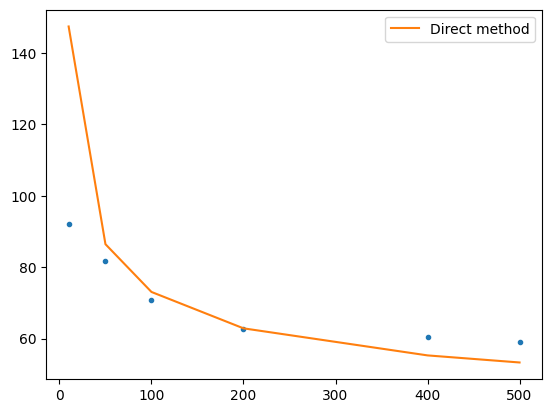

In [24]:
df = pd.read_csv("load_test_meta_H100_2.csv", sep=",")

y = df.iloc[:, 8]
output_lengths = df.iloc[:, 7]

x = [10, 50, 100, 200, 400, 500]

y_predict = get_troughput_predictions(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=8e9,
  bytes_per_param=2,
  model_layers=32,
  model_hidden_dim=4096,
  n_gpus=1,
  output_lengths=output_lengths,
  k=1.7
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Direct method")
plt.legend()

Pour Llama 3.1 8b, `k=1.7` donne une prédiction un peu trop importante sur 10 requêtes concurrentes mais le reste est pas trop mal. On pourrait facilement trouver le `k` optimal algorithmiquement mais essayons d'abord de savoir si un `k` constant d'un modèle à un autre permet de bonnes prédictions.

## Mistral small 24b

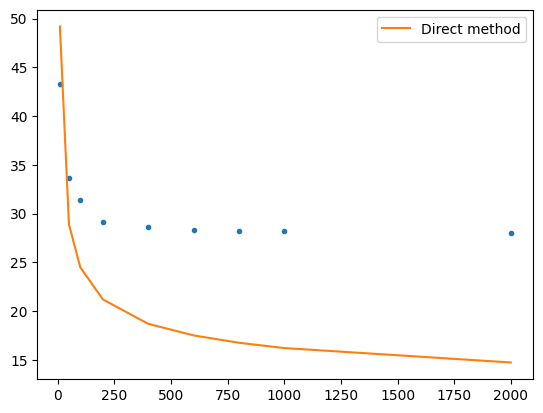

In [25]:
df = pd.read_csv("load_test_mistralai_H100_2.csv", sep=",")

y = df.iloc[:, 8]
output_lengths = df.iloc[:, 7]

x = [10, 50, 100, 200, 400, 600, 800, 1000, 2000]

y_predict = get_troughput_predictions(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  bytes_per_param=2,
  model_layers=40,
  model_hidden_dim=5120,
  n_gpus=1,
  output_lengths=output_lengths,
  k=1.7
)

plt.plot(x, y, ".")
plt.plot(x, y_predict[0], label="Direct method")
plt.legend()

Triste vie :(

Pas de facteur de calibration `k` commun pour différents modèles, on va essayer de trouver une méthode naïve pour obtenir une meilleure valeur de `k` compte tenu des différences entre le modèle (ici mistral small) et llama 3.1 8b pour lequel on est plutôt bien calibré.

In [26]:
base_params = 8e9
base_layers = 32
base_dim = 4096

params = 24e9
layers = 40
dim = 5120

3.0


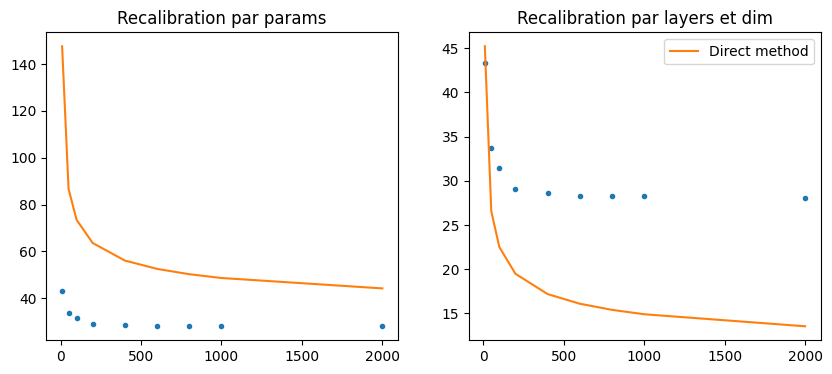

In [27]:
y_predict_0 = get_troughput_predictions(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=params,
  bytes_per_param=2,
  model_layers=layers,
  model_hidden_dim=dim,
  n_gpus=1,
  output_lengths=output_lengths,
  k=1.7*(params/base_params)
)

print((params/base_params))

y_predict_1 = get_troughput_predictions(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=params,
  bytes_per_param=2,
  model_layers=layers,
  model_hidden_dim=dim,
  n_gpus=1,
  output_lengths=output_lengths,
  k=((layers*dim)/(base_layers*base_dim))
)

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(x, y, ".")
axs[0].plot(x, y_predict_0[0], label="Direct method")
axs[0].set_title("Recalibration par params")

axs[1].plot(x, y, ".")
axs[1].plot(x, y_predict_1[0], label="Direct method")
axs[1].set_title("Recalibration par layers et dim")

plt.legend()

La courbe a vraiment l'air de suivre la même allure, on doit pouvoir appliquer un facteur correctif. Après beaucoup de forcing sur Desmos, on trouve effectivement une formule de recalibration qui est intégrée à la nouvelle fonction de prédiction qui suit.

In [28]:
from math import sqrt, log, exp

def predict_throughput(
    concurrent_users: int,
    batch_size: int,
    gpu_throughput: float,
    gpu_bandwidth: float,
    model_params: int,
    model_layers: int,
    model_hidden_dim: int,
    bytes_per_param: float,
    input_length: int = 100,
    output_length: int = 1650,
    n_gpus: int = 1,
    link_bw: float = 100e9,
):
    """
    Latency model with minimal multi‑GPU & small‑model fixes.

    * Tensor‑parallel efficiency and comm‑overhead are modelled explicitly.
    * FLOPs/BW terms use a roofline: time = max(FLOPs/TFLOPs, Bytes/BW).
    * Parameter / KV access is sharded when n_gpus > 1.
    """

    # -------------------------------- calibration -------------------------------- #
    GPU_EFFICIENCY_FACTOR   = 0.55   # fp16 utilisation for large models; tune per GPU
    TP_EFFICIENCY           = 0.85   # tensor‑parallel scaling loss (NVLink H100)
    COMM_OVERHEAD_FRACTION  = 0.15   # all‑reduce latency fudge factor
    # ----------------------------------------------------------------------------- #

    per_gpu_flops   = gpu_throughput * GPU_EFFICIENCY_FACTOR
    per_gpu_bw      = gpu_bandwidth
    aggregate_flops = per_gpu_flops * TP_EFFICIENCY
    aggregate_bw    = per_gpu_bw

    # ---------- decode (one token) ---------- #
    # compute term is sharded
    flops_decode_one = batch_size * (model_params / n_gpus) * 2

    # memory term is also per‑GPU
    mm_params  = model_params / n_gpus
    mm_kv_read = 2 * batch_size * input_length * model_hidden_dim
    mm_kv_write = 2 * batch_size * model_hidden_dim
    mm_decode_one = bytes_per_param * (mm_params + mm_kv_read + mm_kv_write)

    # comm: one all‑reduce of qkv activations per layer (very coarse)
    comm_bytes = model_layers * 2 * model_hidden_dim * 4   # fp16→2 B, 2 directions
    comm_time  = (comm_bytes / link_bw) * COMM_OVERHEAD_FRACTION

    time_decode_one = max(
        flops_decode_one / aggregate_flops,
        mm_decode_one  / aggregate_bw,
    ) + comm_time

    # recalibration
    k = 24e9/model_params
    recalibration_factor = k**(-1/(k+1))

    return (1/(time_decode_one)) * recalibration_factor / log(min(concurrent_users, batch_size)+30,10)

In [29]:
def troughput_predictions(
  x: list,
  batch_size: int,
  gpu_throughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  bytes_per_param: float,
  output_lengths: list,
  model_layers: int,
  model_hidden_dim: int,
  n_gpus: int = 1,
  input_length: int = 100,
):
  direct_pred = []
  for concurrent_users, output_length in zip(x, output_lengths):
    direct_pred.append(predict_throughput(
      concurrent_users=concurrent_users,
      batch_size=batch_size,
      gpu_throughput=gpu_throughput,
      gpu_bandwidth=gpu_bandwidth,
      model_params=model_params,
      model_layers=model_layers,
      model_hidden_dim=model_hidden_dim,
      bytes_per_param=bytes_per_param,
      input_length=input_length,
      output_length=output_length,
      n_gpus=n_gpus
    ))
  return direct_pred

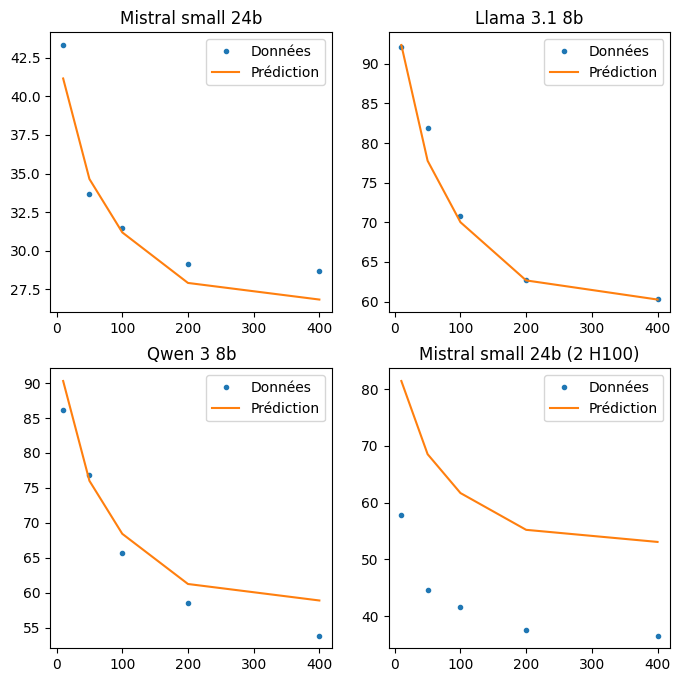

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))

# MISTRAL SMALL 24B

df = pd.read_csv("load_test_mistralai_H100_2.csv", sep=",")
y = df.iloc[:5, 8]
output_lengths = df.iloc[:5, 7]

x = [10, 50, 100, 200, 400]

y_predict_0 = troughput_predictions(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  bytes_per_param=2,
  model_layers=40,
  model_hidden_dim=5120,
  n_gpus=1,
  output_lengths=output_lengths
)

axs[0][0].plot(x, y, ".", label="Données")
axs[0][0].plot(x, y_predict_0, label="Prédiction")
axs[0][0].set_title("Mistral small 24b")
axs[0][0].legend()

# LLAMA 3.1 8B

df = pd.read_csv("load_test_meta_H100_2.csv", sep=",")
y = df.iloc[:5, 8]
output_lengths = df.iloc[:5, 7]

y_predict_1 = troughput_predictions(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=8e9,
  bytes_per_param=2,
  model_layers=32,
  model_hidden_dim=4096,
  n_gpus=1,
  output_lengths=output_lengths
)

axs[0][1].plot(x, y, ".", label="Données")
axs[0][1].plot(x, y_predict_1, label="Prédiction")
axs[0][1].set_title("Llama 3.1 8b")
axs[0][1].legend()

# QWEN 3 8B

df = pd.read_csv("load_test_qwen_H100.csv", sep=",")
y = df.iloc[:5, 8]
output_lengths = df.iloc[:5, 7]

y_predict_2 = troughput_predictions(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=8.2e9,
  bytes_per_param=2,
  model_layers=36,
  model_hidden_dim=4096,
  n_gpus=1,
  output_lengths=output_lengths
)

axs[1][0].plot(x, y, ".", label="Données")
axs[1][0].plot(x, y_predict_2, label="Prédiction")
axs[1][0].set_title("Qwen 3 8b")
axs[1][0].legend()

# MISTRAL SMALL 24B, 2 GPUs

df = pd.read_csv("load_test_mistralai_2H100_2.csv", sep=",")
y = df.iloc[:5, 8]
output_lengths = df.iloc[:5, 7]

y_predict_3 = troughput_predictions(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  bytes_per_param=2,
  model_layers=40,
  model_hidden_dim=5120,
  n_gpus=2,
  output_lengths=output_lengths
)

axs[1][1].plot(x, y, ".", label="Données")
axs[1][1].plot(x, y_predict_3, label="Prédiction")
axs[1][1].set_title("Mistral small 24b (2 H100)")
axs[1][1].legend()

On se situe dans un intervalle de +-10% autour de la valeur mesurée empiriquement, qui est elle-même un moyenne de 5 tests avec un écart-type similaire. Autrement-dit, la recalibration marche !

En revanche, on remarque que notre formule actuelle pour le calcul initial du thoughput ne s'adapte pas correctement à la parallélisation sur plusieurs GPUs. On va devoir la retravailler.

## Troughput (5th percentile)

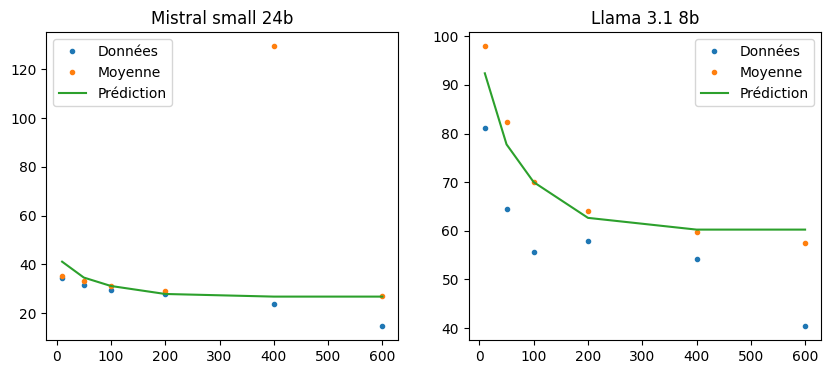

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# MISTRAL SMALL 24B

df = pd.read_csv("load_test_mistralai_H100_std.csv", sep=",")
y = df.loc[:, "p5_tokens_per_second"]
ref = df.loc[:, "avg_tokens_per_second"]
output_lengths = df.loc[:, "avg_token_count"]

x = [10, 50, 100, 200, 400, 600]

y_predict_0 = troughput_predictions(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  bytes_per_param=2,
  model_layers=40,
  model_hidden_dim=5120,
  n_gpus=1,
  output_lengths=output_lengths
)

axs[0].plot(x, y, ".", label="Données")
axs[0].plot(x, ref, ".", label="Moyenne")
axs[0].plot(x, y_predict_0, label="Prédiction")
axs[0].set_title("Mistral small 24b")
axs[0].legend()

# LLAMA 3.1 8B

df = pd.read_csv("load_test_meta_H100_std.csv", sep=",")
y = df.loc[:, "p5_tokens_per_second"]
ref = df.loc[:, "avg_tokens_per_second"]
output_lengths = df.loc[:, "avg_token_count"]

y_predict_1 = troughput_predictions(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=8e9,
  bytes_per_param=2,
  model_layers=32,
  model_hidden_dim=4096,
  n_gpus=1,
  output_lengths=output_lengths
)

axs[1].plot(x, y, ".", label="Données")
axs[1].plot(x, ref, ".", label="Moyenne")
axs[1].plot(x, y_predict_1, label="Prédiction")
axs[1].set_title("Llama 3.1 8b")
axs[1].legend()

On remarque un outlier à 400 requêtes concurrentes pour mistral small qu'on va ignorer. Pour le reste, un facteur multiplicatif semble pouvoir faire l'affaire tant que le nombre de requêtes est inférieur à la `max_batch_size`. Passé ce seuil, une nouvelle relation décroissante semble se dessiner. Dans la mesure où nous cherchons sourtout à faire de bonnes prédictions en amont de la batch size maximale, nous ne chercherons pas à nous adapter à cette nouvelle relation, d'autant qu'il est probable que la variance au niveau du 5e percentile de débit explose à saturation du batch, ce qui rend le travail prédictif d'autant plus complexe.

## TTFT (95e percentile)

In [32]:
from speed_constraint import calculate_latency_metrics
from math import ceil

def _predict_ttft_95(
  concurrent_users: int, 
  batch_size: int,
  gpu_throughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  model_layers: int,
  model_hidden_dim: int,
  bytes_per_param: float,
  input_length: int = 100,
  output_length: int = 1650,
  n_gpus: int = 1,
):
    """
    Calcul du TTFT moyen à partir des formules de calculate_speed_constraint dans speed_constraint.py
    Le code commenté correspond aux formules de calculate_latency_metrics mais est moins fiable
    """
    GPU_EFFICIENCY_FACTOR = 0.55  # Default efficiency factor (~55% for fp16)
    MULTI_GPU_INEFFICIENCY_FACTOR = 0.85
    
    effective_bandwidth = gpu_bandwidth * (1 + (n_gpus - 1) * MULTI_GPU_INEFFICIENCY_FACTOR)
    effective_gpu_flops = (gpu_throughput * GPU_EFFICIENCY_FACTOR) * (1 + (n_gpus - 1) * MULTI_GPU_INEFFICIENCY_FACTOR)

    effective_batchs = ceil(concurrent_users / batch_size)
    wait_factor = ((effective_batchs - 1) * effective_batchs / 2) / concurrent_users

    # flops_per_token = model_params * 2
    # gpu_tps = effective_gpu_flops / flops_per_token

    # latency_metrics = calculate_latency_metrics(
    #     gpu_tps, input_length, output_length, batch_size
    # )
    
    # return latency_metrics["ttft_ms"] / 1000 + latency_metrics["total_time_s"] * wait_factor

    generated_tokens = output_length

    flops_prefill = 2 * batch_size * model_layers * input_length * model_hidden_dim * (2*model_hidden_dim + input_length)
    mm_prefill = bytes_per_param * (model_params + 2 * model_layers * batch_size * input_length * model_hidden_dim + batch_size * input_length * model_hidden_dim)
    time_prefill = max(flops_prefill / effective_gpu_flops, mm_prefill / effective_bandwidth)

    tokens_troughput = predict_throughput(
        concurrent_users=concurrent_users,
        batch_size=batch_size,
        gpu_throughput=gpu_throughput,
        gpu_bandwidth=gpu_bandwidth,
        model_params=model_params,
        model_layers=model_layers,
        model_hidden_dim=model_hidden_dim,
        bytes_per_param=bytes_per_param,
        input_length=input_length,
        output_length=output_length,
        n_gpus=n_gpus
    )

    # print(f"users: {concurrent_users}, time_prefill: {time_prefill}, tps: {1/time_decode_one_token}")

    total_time = time_prefill + (generated_tokens - 1) * 1/tokens_troughput

    return time_prefill + wait_factor * total_time

def predict_ttft_95(
  x: list,
  batch_size: int,
  gpu_throughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  bytes_per_param: float,
  output_lengths: list,
  model_layers: int,
  model_hidden_dim: int,
  n_gpus: int = 1,
  input_length: int = 100,
):
  direct_pred = []
  for concurrent_users, output_length in zip(x, output_lengths):
    direct_pred.append(_predict_ttft_95(
      concurrent_users=concurrent_users,
      batch_size=batch_size,
      gpu_throughput=gpu_throughput,
      gpu_bandwidth=gpu_bandwidth,
      model_params=model_params,
      model_layers=model_layers,
      model_hidden_dim=model_hidden_dim,
      bytes_per_param=bytes_per_param,
      input_length=input_length,
      output_length=output_length,
      n_gpus=n_gpus
    ))
  return direct_pred



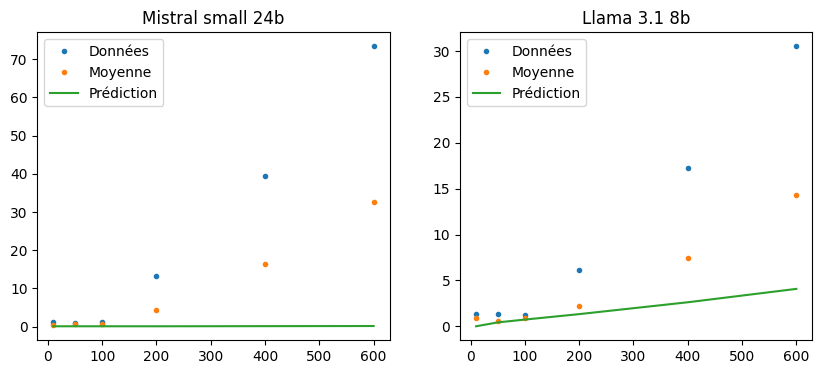

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# MISTRAL SMALL 24B

df = pd.read_csv("load_test_mistralai_H100_std.csv", sep=",")
y = df.loc[:, "95_percentile_time_to_first_token"]
ref = df.loc[:, "avg_time_to_first_token"]
output_lengths = df.loc[:, "avg_token_count"]

x = [10, 50, 100, 200, 400, 600]

y_predict_0 = predict_ttft_95(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  bytes_per_param=2,
  model_layers=40,
  model_hidden_dim=5120,
  n_gpus=1,
  output_lengths=output_lengths
)

axs[0].plot(x, y, ".", label="Données")
axs[0].plot(x, ref, ".", label="Moyenne")
axs[0].plot(x, y_predict_0, label="Prédiction")
axs[0].set_title("Mistral small 24b")
axs[0].legend()

# LLAMA 3.1 8B

df = pd.read_csv("load_test_meta_H100_std.csv", sep=",")
y = df.loc[:, "95_percentile_time_to_first_token"]
ref = df.loc[:, "avg_time_to_first_token"]
output_lengths = df.loc[:, "avg_token_count"]

y_predict_1 = predict_ttft_95(
  x=x,
  batch_size=sqrt(256),
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=8e9,
  bytes_per_param=2,
  model_layers=32,
  model_hidden_dim=4096,
  n_gpus=1,
  output_lengths=output_lengths
)

axs[1].plot(x, y, ".", label="Données")
axs[1].plot(x, ref, ".", label="Moyenne")
axs[1].plot(x, y_predict_1, label="Prédiction")
axs[1].set_title("Llama 3.1 8b")
axs[1].legend()

On pourrait se contenter de ça mais on va ressortir nos méthodes de prédiction qui mobilisent la théorie des files d'attente pour voir si elles peuvent mieux performer.

In [34]:
import queue_analysis
from queue_analysis import mm1_transient_mean, mm1_transient_percentile, _mm1_uniformised_dist
importlib.reload(queue_analysis)
from math import ceil, exp

def _predict_ttft_queue_theory(
  concurrent_users: int, 
  batch_size: int,
  gpu_throughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  bytes_per_param: float,
  model_layers: int = 2,
  model_hidden_dim: int = 2,
  n_gpus: int = 1,
  input_length: int = 100,
  output_length: int = 1650,
  link_bw: float = 100e9,
  ):
    """
    Calcul du TTFT moyen à partir d'un modèle de file d'attente M/M/c dont on
    estime les probabilités transcientes avec les méthodes de queue_analysis.py
    """
    
    theta = 0.5 # hyperparamètre qui dépend du comportement des utilisteurs
    h100_bandwidth = 3.2e12 # pour recalibration sur d'autres GPUs
    mistral_small_layers = 40 # pour recalibration sur d'autres modèles

    output_length = 1650 / 4

    # -------------------------------- calibration -------------------------------- #
    GPU_EFFICIENCY_FACTOR   = 0.55   # fp16 utilisation for large models; tune per GPU
    TP_EFFICIENCY           = 0.85   # tensor‑parallel scaling loss (NVLink H100)
    COMM_OVERHEAD_FRACTION  = 0.15   # all‑reduce latency fudge factor
    # ----------------------------------------------------------------------------- #

    per_gpu_flops   = gpu_throughput * GPU_EFFICIENCY_FACTOR
    per_gpu_bw      = gpu_bandwidth
    aggregate_flops = per_gpu_flops * n_gpus * TP_EFFICIENCY
    aggregate_bw    = per_gpu_bw  * n_gpus

    # queueing / batching
    effective_batch_size = min(batch_size, concurrent_users)
    effective_batches = ceil(concurrent_users / batch_size)
    wait_factor = ((effective_batches - 1) * effective_batches / 2) / concurrent_users

    # ---------- pre‑fill (prompt) ---------- #
    flops_prefill = (
        2 * batch_size * model_layers * input_length * model_hidden_dim
        * (2 * model_hidden_dim + input_length)
    )
    mm_prefill = bytes_per_param * (
        model_params
        + 2 * model_layers * batch_size * input_length * model_hidden_dim
        + batch_size * input_length * model_hidden_dim
    )
    time_prefill = max(flops_prefill / aggregate_flops, mm_prefill / aggregate_bw)

    # ---------- decode (one token) ---------- #
    tokens_troughput = predict_throughput(
        concurrent_users=concurrent_users,
        batch_size=batch_size,
        gpu_throughput=gpu_throughput,
        gpu_bandwidth=gpu_bandwidth,
        model_params=model_params,
        model_layers=model_layers,
        model_hidden_dim=model_hidden_dim,
        bytes_per_param=bytes_per_param,
        input_length=input_length,
        output_length=output_length,
        n_gpus=n_gpus
    )

    # ---------- total ---------- #
    generated_tokens = output_length
    time_per_request = time_prefill + (generated_tokens - 1) * 1/tokens_troughput

    # paramètres de la queue
    mu_heuristic = 2*(h100_bandwidth/gpu_bandwidth) * (mistral_small_layers/model_layers)
    λ = concurrent_users / time_per_request
    μ = (1/time_per_request) * batch_size

    μ = μ if μ < λ else μ

    # calculs
    t = ceil(time_per_request)
    print(f"users = {concurrent_users}, λ = {λ}, μ = {μ}, t = {t}")
    mean_queue_length = mm1_transient_mean(λ, μ, t, n_states=1000)
    p95_queue_length = mm1_transient_percentile(λ, μ, t, 0.95, n_states=1000)

    wait_time = mean_queue_length / μ
    p95_wait_time = p95_queue_length / μ

    # print(f"λ = {round(λ, 3)}, μ = {round(μ, 3)}, t = {round(time_per_request, 3)}, tps = {round(1/time_decode_one, 3)}, W(1) = {round(wait_time, 3)}, L(1) = {mean_queue_length}")

    return time_prefill + wait_time, time_prefill + p95_wait_time

def predict_ttft_queue_theory(
  x: list,
  batch_size: int,
  gpu_throughput: float, 
  gpu_bandwidth: float, 
  model_params: int, 
  bytes_per_param: float,
  output_lengths: list,
  model_layers: int,
  model_hidden_dim: int,
  n_gpus: int = 1,
  input_length: int = 100,
):
  mean_pred = []
  p95_pred = []
  for concurrent_users, output_length in zip(x, output_lengths):
    pred = _predict_ttft_queue_theory(
      concurrent_users=concurrent_users,
      batch_size=batch_size,
      gpu_throughput=gpu_throughput,
      gpu_bandwidth=gpu_bandwidth,
      model_params=model_params,
      model_layers=model_layers,
      model_hidden_dim=model_hidden_dim,
      bytes_per_param=bytes_per_param,
      input_length=input_length,
      output_length=output_length,
      n_gpus=n_gpus
    )
    mean_pred.append(pred[0])
    p95_pred.append(pred[1])
  return mean_pred, p95_pred


users = 10, λ = 0.9884784728275999, μ = 25.30504890438656, t = 11
users = 50, λ = 4.168240619971637, μ = 21.34139197425478, t = 12
users = 100, λ = 7.512283173423313, μ = 19.231444923963682, t = 14
users = 200, λ = 13.460666461887937, μ = 17.22965307121656, t = 15
users = 400, λ = 25.891979285979726, μ = 16.570866743027025, t = 16
users = 600, λ = 38.837968928969595, μ = 16.570866743027025, t = 16
users = 10, λ = 2.215117878707761, μ = 56.70701769491868, t = 5
users = 50, λ = 9.343337947412884, μ = 47.83789029075397, t = 6
users = 100, λ = 16.84166140125555, μ = 43.1146531872142, t = 6
users = 200, λ = 30.181442538728785, μ = 38.63224644957285, t = 7
users = 400, λ = 58.05753283219256, μ = 37.15682101260324, t = 7
users = 600, λ = 87.08629924828884, μ = 37.15682101260324, t = 7


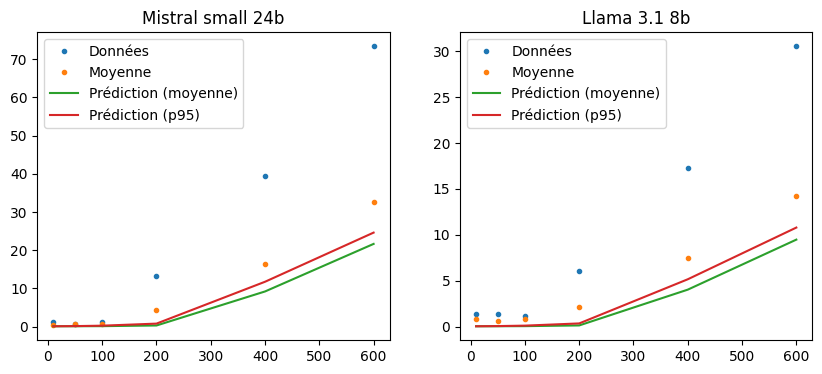

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# MISTRAL SMALL 24B

df = pd.read_csv("load_test_mistralai_H100_std.csv", sep=",")
y = df.loc[:, "95_percentile_time_to_first_token"]
ref = df.loc[:, "avg_time_to_first_token"]
output_lengths = df.loc[:, "avg_token_count"]

x = [10, 50, 100, 200, 400, 600]

y_predict_0 = predict_ttft_queue_theory(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=24e9,
  bytes_per_param=2,
  model_layers=40,
  model_hidden_dim=5120,
  n_gpus=1,
  output_lengths=output_lengths
)

axs[0].plot(x, y, ".", label="Données")
axs[0].plot(x, ref, ".", label="Moyenne")
axs[0].plot(x, y_predict_0[0], label="Prédiction (moyenne)")
axs[0].plot(x, y_predict_0[1], label="Prédiction (p95)")
axs[0].set_title("Mistral small 24b")
axs[0].legend()

# LLAMA 3.1 8B

df = pd.read_csv("load_test_meta_H100_std.csv", sep=",")
y = df.loc[:, "95_percentile_time_to_first_token"]
ref = df.loc[:, "avg_time_to_first_token"]
output_lengths = df.loc[:, "avg_token_count"]

y_predict_1 = predict_ttft_queue_theory(
  x=x,
  batch_size=256,
  gpu_throughput=1.98e15,
  gpu_bandwidth=3.2e12,
  model_params=8e9,
  bytes_per_param=2,
  model_layers=32,
  model_hidden_dim=4096,
  n_gpus=1,
  output_lengths=output_lengths
)

axs[1].plot(x, y, ".", label="Données")
axs[1].plot(x, ref, ".", label="Moyenne")
axs[1].plot(x, y_predict_1[0], label="Prédiction (moyenne)")
axs[1].plot(x, y_predict_1[1], label="Prédiction (p95)")
axs[1].set_title("Llama 3.1 8b")
axs[1].legend()

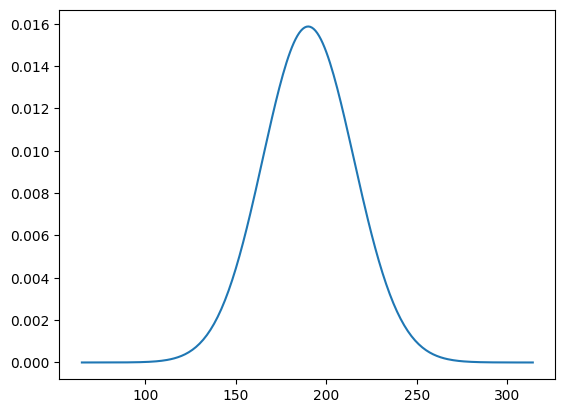

In [36]:
import matplotlib.pyplot as plt
from queue_analysis import _mm1_uniformised_dist

dist = _mm1_uniformised_dist(25.89, 14.08, 16, n_states=1000)

plt.plot(np.arange(65, 315), dist[65:315])
plt.show()

In [37]:
import numpy as np

m1 = np.sum([k * p for k, p in enumerate(dist)])
m2 = np.sum([k**2 * p for k, p in enumerate(dist)])

print(m1)

print(sqrt(m2 - m1**2))

190.15220999129838
25.133230513890393


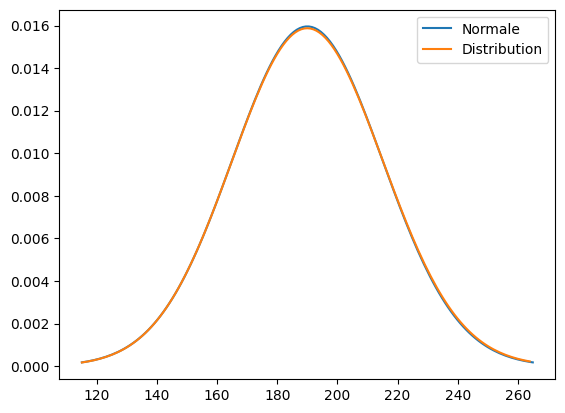

In [38]:
import scipy.stats as stats
import math

mu = 190
sigma = 25

x = np.linspace(mu - 3*sigma, mu + 3*sigma, sigma*6)
ndist = stats.norm.pdf(x, mu, sigma)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label="Normale")
plt.plot(np.arange(115, 265), dist[115:265], label="Distribution")
plt.legend()
plt.show()

In [39]:
mm1_transient_mean(25.89, 14.08, 16, n_states=1000)

190.15220999129835

In [40]:
mm1_transient_percentile(25.89, 14.08, 16, percentile=0.95, n_states=1000)

232

In [41]:
348/14

24.857142857142858